**This is a continuation of the One Author Advanced Project, where I will be "manually" cross validating and grid searching in order to find an optimal model and confirm the results of the "One_Author_Advanced" notebook**

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, fbeta_score
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import itertools
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.calibration import CalibratedClassifierCV
from statistics import mean
from scipy.sparse import hstack, csr_matrix

Reading in the dataset used in the One_Author_advanced notebook

In [2]:
df = pd.read_csv('E:/OtherCodeProjects/Springboard Capstone Projects/Springboard-Capstone-1-Data/one_author_advanced_data.csv')

df.head()

,year,paper_text,paper_id,title_len,paper_len,avg_word_len,Oral,Poster,Spotlight,Unknown,is_bernhard
0,2016,Consistent Kernel Mean Estimation\nfor Functio...,6545,67,33747,4.488406,0,1,0,0,1
1,2008,Bayesian Experimental Design of Magnetic\nReso...,3558,68,33280,4.916890,0,0,0,1,1
2,1998,Kernel peA and De-Noising in Feature Spaces\n\...,1491,43,22127,4.798472,0,0,0,1,1
3,1998,Semiparametric Support Vector and\nLinear Prog...,1575,61,18571,4.874520,0,0,0,1,1
4,2016,Minimax Estimation of Maximum Mean Discrepancy...,6483,66,29683,3.954461,0,1,0,0,1


Setting up X (features) and y (target feature)

In [3]:
exclude = ['paper_id', 'is_bernhard']
X = df[df.columns.difference(exclude)]

y = df['is_bernhard'].values.flatten()

Scaling the other features so they are usable by the model

In [4]:
scaled_feat = X[X.columns.difference(['paper_text'])]
paper_text = pd.DataFrame(X.paper_text)

minmax = MinMaxScaler()
scaled_feat = pd.DataFrame(minmax.fit_transform(scaled_feat), columns=scaled_feat.columns)
X = scaled_feat.join(paper_text)
X

,Oral,Poster,Spotlight,Unknown,avg_word_len,paper_len,title_len,year,paper_text
0,0.0,1.0,0.0,0.0,0.409777,0.271676,0.410596,0.966667,Consistent Kernel Mean Estimation\nfor Functio...
1,0.0,0.0,0.0,1.0,0.477693,0.267896,0.417219,0.700000,Bayesian Experimental Design of Magnetic\nReso...
2,0.0,0.0,0.0,1.0,0.458923,0.177621,0.251656,0.366667,Kernel peA and De-Noising in Feature Spaces\n\...
3,0.0,0.0,0.0,1.0,0.470977,0.148838,0.370861,0.366667,Semiparametric Support Vector and\nLinear Prog...
4,0.0,1.0,0.0,0.0,0.325145,0.238781,0.403974,0.966667,Minimax Estimation of Maximum Mean Discrepancy...
...,...,...,...,...,...,...,...,...,...
7234,0.0,0.0,0.0,1.0,0.422588,0.281098,0.437086,0.700000,Linear Classification and Selective Sampling\n...
7235,0.0,0.0,0.0,1.0,0.510911,0.126619,0.324503,0.100000,Generalization Dynamics in\nLMS Trained Linear...
7236,0.0,0.0,0.0,1.0,0.436957,0.254209,0.430464,0.700000,MAS: a multiplicative approximation scheme for...
7237,0.0,0.0,0.0,1.0,0.443642,0.264076,0.198675,0.700000,Clustering via LP-based Stabilities\n\nNikos K...


**Testing Tfidf hyperparameters**

In order to check if stop words have an impact on the final model I have set up a large for loop that contains the Tfidf vectorizer and a basic logistic regression model. The default 'english' stop word set was tested agains no stop words, and the results cross validated five times across five random states for the train_test split. The final results for each model are then averaged together and saved in a dictionary.

In [5]:
Tfidf_stop_words = [None, 'english']

In [6]:
random_states = [0, 1, 2, 3, 4]

In [7]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
LR_dict = {'Tfidf_Stop_Words': [],
            'avg_Train_auc': [],
            'avg_Test_auc': []}

run = 0
for stop_word in Tfidf_stop_words:

    # Appending the parameters for this run to my dictionary
    LR_dict['Tfidf_Stop_Words'].append(str(stop_word))

    auc_train_scores = []
    auc_test_scores = []
    for random_state in random_states:

        # Counting what iteration I am on
        print(run)
        run += 1

        # Initializing the TfidfVectorizer with different stop words, then .fit_transforming it on the train set
        # and .transforming on the test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, train_size=0.75, stratify=y)

        other_features_train = csr_matrix(X_train[X_train.columns.difference(['paper_text'])].values)
        other_features_test = csr_matrix(X_test[X_test.columns.difference(['paper_text'])].values)

        tfidf = TfidfVectorizer(stop_words=stop_word)

        X_train_vector = tfidf.fit_transform(X_train.paper_text)
        X_test_vector = tfidf.transform(X_test.paper_text)

        X_train_tfidf = hstack([other_features_train, X_train_vector])
        X_test_tfidf = hstack([other_features_test, X_test_vector])

        # Making a pipeline with the logistic regressor inside, the C hyperparameter is chosen here
        pipe = Pipeline(steps=[
            ('LR', LogisticRegression(class_weight='balanced', C=1, max_iter=1000)),
            
        ])

        # Fitting the pipeline to the train set and predicting on both train and test sets
        pipe.fit(X_train_tfidf, y_train)
        pipe_train_pred = pipe.predict(X_train_tfidf)
        pipe_test_pred = pipe.predict(X_test_tfidf)

        # Finding the roc_auc_score for both
        auc_train = roc_auc_score(y_train, pipe_train_pred)
        auc_test = roc_auc_score(y_test, pipe_test_pred)

        #Appending the scores to the list outside the loop
        auc_train_scores.append(auc_train)
        auc_test_scores.append(auc_test)

    # Appending the scores to the dictionary
    LR_dict['avg_Train_auc'].append(mean(auc_train_scores))
    LR_dict['avg_Test_auc'].append(mean(auc_test_scores))

0
1
2
3
4
5
6
7
8
9


Using Tfidf inside the loop is time consuming, so I will recreate the above code without the TfidfVectorizer in the loop to test other models. Using no stop words gives better results across the models, so that is what I will use from here.

In [8]:
tfidf_HPtable = pd.DataFrame.from_dict(LR_dict) 
tfidf_HPtable.sort_values(by='avg_Test_auc', ascending=False, inplace=True)
tfidf_HPtable

,Tfidf_Stop_Words,avg_Train_auc,avg_Test_auc
0,None,0.994798,0.749282
1,english,0.996991,0.726233


The X_train and X_test I will use to test three seperate models and their hyperparameters. 

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=16, train_size=0.75, stratify=y)

other_features_train = csr_matrix(X_train[X_train.columns.difference(['paper_text'])].values)
other_features_test = csr_matrix(X_test[X_test.columns.difference(['paper_text'])].values)

tfidf = TfidfVectorizer()

X_train_vector = tfidf.fit_transform(X_train.paper_text)
X_test_vector = tfidf.transform(X_test.paper_text)

X_train = hstack([other_features_train, X_train_vector])
X_test = hstack([other_features_test, X_test_vector])

I will first test the LogisticRegression model, with the regularization parameter (C) and the sampling of the features as my hyperparameters. I chose a range of C values from 1 down to 0.001; and the sampling being none (using class weights instead), random oversampling, and random undersampling. 

In [124]:
C = [10, 5, 1, 0.5, 0.1, 0.05, 0.01,]

In [125]:
samplers = ['None', 'ros', 'rus']

In [126]:
hyperparameters = list(itertools.product(
                        C, samplers
))

hyperparameters

[(10, 'None'),
 (10, 'ros'),
 (10, 'rus'),
 (5, 'None'),
 (5, 'ros'),
 (5, 'rus'),
 (1, 'None'),
 (1, 'ros'),
 (1, 'rus'),
 (0.5, 'None'),
 (0.5, 'ros'),
 (0.5, 'rus'),
 (0.1, 'None'),
 (0.1, 'ros'),
 (0.1, 'rus'),
 (0.05, 'None'),
 (0.05, 'ros'),
 (0.05, 'rus'),
 (0.01, 'None'),
 (0.01, 'ros'),
 (0.01, 'rus')]

This test uses the block of code from the Tfidf test, but modified so that it tracks the F1_score and precision as well as the roc_auc, and saves the best model for each. Precision minimizes false positives, while F1_score balances between precision and recall (which minimizes false negatives). For all subsequent models I will need to choose a consistent metric to score on, and this will show me what optimizing for a particular metric looks like.

In [127]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
LR_dict = {'LogReg_C_value' : [],
            'Sampler': [],
            'Precision': [],
            'F2_score_test': [],
            'Train_auc': [],
            'Test_auc': []}

run = 0
best_score_precision = 0
best_LR_model_precision = None
best_score_F1 = 0
best_LR_model_F1 = None
best_score_auc = 0
best_LR_model_auc = None

for C_value, sampler_type in hyperparameters:

    # Counting what iteration I am on
    print(run)
    run += 1
    
    # Appending the parameters for this run to my dictionary
    LR_dict['LogReg_C_value'].append(C_value)
    LR_dict['Sampler'].append(sampler_type)

    # Making pipelines for each sampler type, with the C value used within
    if sampler_type == 'rus':
        pipe = Pipeline(steps=[
            ('rus', RandomUnderSampler(random_state=21)),
            ('LR', LogisticRegression(C=C_value, max_iter=1000))
            ])

    elif sampler_type == 'ros':
        pipe = Pipeline(steps=[
            ('ros', RandomOverSampler(random_state=21)),
            ('LR', LogisticRegression(C=C_value, max_iter=1000))
            ])

    else:
        pipe = Pipeline(steps=[
            ('LR', LogisticRegression(class_weight='balanced', C=C_value, max_iter=1000))
            ])

    # Fitting the pipeline to the train set and predicting on both train and test sets
    pipe.fit(X_train, y_train)
    pipe_train_pred = pipe.predict(X_train)
    pipe_test_pred = pipe.predict(X_test)

    # Finding the roc_auc_score for both, I am including precision as in the past 
    # undersampling has led to awful precision scores
    precision = precision_score(y_test, pipe_test_pred)
    F1_score = fbeta_score(y_test, pipe_test_pred, beta=2)
    auc_train = roc_auc_score(y_train, pipe_train_pred)
    auc_test = roc_auc_score(y_test, pipe_test_pred)

    # Appending the scores to the dictionary
    LR_dict['Precision'].append(precision)
    LR_dict['F2_score_test'].append(F1_score)
    LR_dict['Train_auc'].append(auc_train)
    LR_dict['Test_auc'].append(auc_test)

    # Saving the best model
    if precision > best_score_precision:
        best_score_precision = precision
        best_LR_model_precision = pipe

    if F1_score > best_score_F1:
        best_score_F1 = F1_score
        best_LR_model_F1 = pipe

    if auc_test > best_score_auc:
        best_score_auc = auc_test
        best_LR_model_auc = pipe

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


The full hyperparameter table for the LogisticRegression test.

In [128]:
LR_HPtable = pd.DataFrame.from_dict(LR_dict) 
LR_HPtable.sort_values(by='F2_score_test', ascending=False, inplace=True)
LR_HPtable['Model'] = 'LogisticRegression'
LR_HPtable

,LogReg_C_value,Sampler,Precision,F2_score_test,Train_auc,Test_auc,Model
6,1.00,None,0.333333,0.494505,0.994334,0.776233,LogisticRegression
10,0.50,ros,0.310345,0.483871,0.994148,0.775676,LogisticRegression
9,0.50,None,0.250000,0.480769,0.990804,0.804139,LogisticRegression
7,1.00,ros,0.363636,0.465116,0.996470,0.746098,LogisticRegression
3,5.00,None,0.466667,0.443038,0.998700,0.716520,LogisticRegression
1,10.00,ros,0.666667,0.410959,0.999443,0.686664,LogisticRegression
0,10.00,None,0.545455,0.400000,0.998978,0.686106,LogisticRegression
4,5.00,ros,0.545455,0.400000,0.998978,0.686106,LogisticRegression
13,0.10,ros,0.144928,0.375940,0.986346,0.796056,LogisticRegression
16,0.05,ros,0.102041,0.308642,0.968789,0.787974,LogisticRegression


Optimizing for precision gets a model that has a very low number (relatively) of false positives. In this case it produced the same model as optimizing for F1_score. However, in other tests it might be too conservative a metric.

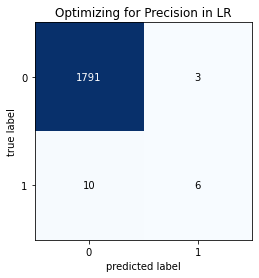

In [15]:
best_LR_model_precision.fit(X_train, y_train)
best_LR_pred = best_LR_model_precision.predict(X_test)
best_LR_cm_test = confusion_matrix(y_test, best_LR_pred)
fig, ax = plot_confusion_matrix(conf_mat=best_LR_cm_test)
plt.title('Optimizing for Precision in LR')
plt.show()

Optimizing for F1_score makes a model that balances between precision (fewer false positives) and recall (fewer false negatives).

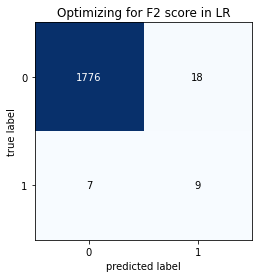

In [16]:
best_LR_model_F1.fit(X_train, y_train)
best_LR_pred = best_LR_model_F1.predict(X_test)
best_LR_cm_test = confusion_matrix(y_test, best_LR_pred)
fig, ax = plot_confusion_matrix(conf_mat=best_LR_cm_test)
plt.title('Optimizing for F2 score in LR')
plt.show()

predicting for roc_auc in this case produces a model that predicts two more papers but also greatly increases the false positive rate. This is probably too aggressive a metric.

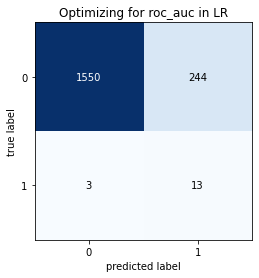

In [17]:
best_LR_model_auc.fit(X_train, y_train)
best_LR_pred = best_LR_model_auc.predict(X_test)
best_LR_cm_test = confusion_matrix(y_test, best_LR_pred)
fig, ax = plot_confusion_matrix(conf_mat=best_LR_cm_test)
plt.title('Optimizing for roc_auc in LR')
plt.show()

I will use F2 score (5 * (precision * recall) / (4 * precision + recall)) for the following models

Now I will test the LinearSVC model, as SVC took too long to train. I am testing the same hyperparameters (C and the three different samplers) as I was with the LogisticRegression.

In [18]:
C = [10, 5, 1, 0.5, 0.1, 0.05, 0.01,]

In [19]:
samplers = ['None', 'ros', 'rus']

In [20]:
hyperparameters = list(itertools.product(
                        C, samplers
))

hyperparameters

[(10, 'None'),
 (10, 'ros'),
 (10, 'rus'),
 (5, 'None'),
 (5, 'ros'),
 (5, 'rus'),
 (1, 'None'),
 (1, 'ros'),
 (1, 'rus'),
 (0.5, 'None'),
 (0.5, 'ros'),
 (0.5, 'rus'),
 (0.1, 'None'),
 (0.1, 'ros'),
 (0.1, 'rus'),
 (0.05, 'None'),
 (0.05, 'ros'),
 (0.05, 'rus'),
 (0.01, 'None'),
 (0.01, 'ros'),
 (0.01, 'rus')]

In [22]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
SVC_dict = {'SVC_C_value' : [],
            'Sampler': [],
            'F2_score_train': [],
            'F2_score_test': []}

run = 0
best_score_F1 = 0
best_SVC_model = None

for C_value, sampler_type in hyperparameters:

    # Counting what iteration I am on
    print(run)
    run += 1
    
    # Appending the parameters for this run to my dictionary
    SVC_dict['SVC_C_value'].append(C_value)
    SVC_dict['Sampler'].append(sampler_type)

    # Making pipelines for each sampler type, with the C value used within
    if sampler_type == 'rus':
        pipe = Pipeline(steps=[
            ('rus', RandomUnderSampler(random_state=21)),
            ('SVC', LinearSVC(C=C_value))
            ])

    elif sampler_type == 'ros':
        pipe = Pipeline(steps=[
            ('ros', RandomOverSampler(random_state=21)),
            ('SVC', LinearSVC(C=C_value))
            ])

    else:
        pipe = Pipeline(steps=[
            ('SVC', LinearSVC(class_weight='balanced', C=C_value))
            ])

    # Fitting the pipeline to the train set and predicting on both train and test sets
    pipe.fit(X_train, y_train)
    pipe_train_pred = pipe.predict(X_train)
    pipe_test_pred = pipe.predict(X_test)

    # Finding the roc_auc_score for both, I am including precision as in the past 
    # undersampling has led to awful precision scores
    F1_score_train = fbeta_score(y_train, pipe_train_pred, beta=2)
    F1_score_test = fbeta_score(y_test, pipe_test_pred, beta=2)

    # Appending the scores to the dictionary
    SVC_dict['F2_score_train'].append(F1_score_train)
    SVC_dict['F2_score_test'].append(F1_score_test)


    # Saving the best model
    if F1_score_test > best_score_F1:
        best_score_F1 = F1_score_test
        best_SVC_model = pipe

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


The hyperparameter table for the SVC model. Overall it looks pretty similar to the logistic regression model.

In [121]:
SVC_HPtable = pd.DataFrame.from_dict(SVC_dict) 
SVC_HPtable.sort_values(by='F2_score_test', ascending=False, inplace=True)
SVC_HPtable['Model'] = 'LinearSVC'
SVC_HPtable

,SVC_C_value,Sampler,F2_score_train,F2_score_test,Model
12,0.10,None,0.836364,0.523256,LinearSVC
16,0.05,ros,0.836364,0.517241,LinearSVC
15,0.05,None,0.730159,0.495050,LinearSVC
13,0.10,ros,0.931174,0.493827,LinearSVC
19,0.01,ros,0.621622,0.390625,LinearSVC
10,0.50,ros,0.982906,0.357143,LinearSVC
3,5.00,None,1.000000,0.357143,LinearSVC
6,1.00,None,0.982906,0.357143,LinearSVC
7,1.00,ros,0.995671,0.357143,LinearSVC
9,0.50,None,0.966387,0.347222,LinearSVC


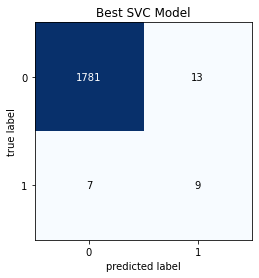

In [24]:
best_SVC_model.fit(X_train, y_train)
best_SVC_pred = best_SVC_model.predict(X_test)
best_SVC_cm_test = confusion_matrix(y_test, best_SVC_pred)
fig, ax = plot_confusion_matrix(conf_mat=best_SVC_cm_test)
plt.title('Best SVC Model')
plt.show()

Now I'm testing a Random Forest Classifier. Here the hyperparameters are n_estimators (the number of 'trees' in the forest), and the same samplers as before. 

In [25]:
n_estimators = [int(n) for n in np.logspace(start=2, stop=3, num=5)]

In [26]:
samplers = ['None', 'ros', 'rus']

In [27]:
hyperparameters = list(itertools.product(
                        n_estimators, samplers
))

hyperparameters

[(100, 'None'),
 (100, 'ros'),
 (100, 'rus'),
 (177, 'None'),
 (177, 'ros'),
 (177, 'rus'),
 (316, 'None'),
 (316, 'ros'),
 (316, 'rus'),
 (562, 'None'),
 (562, 'ros'),
 (562, 'rus'),
 (1000, 'None'),
 (1000, 'ros'),
 (1000, 'rus')]

In [28]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
RFC_dict = {'n_estimators': [],
            'Sampler': [],
            'F2_score_train': [],
            'F2_score_test': []}

run = 0
best_score_F1 = 0
best_RFC_model = None

for n_estimator, sampler_type in hyperparameters:

    # Counting what iteration I am on
    print(run)
    run += 1
    
    # Appending the parameters for this run to my dictionary
    RFC_dict['Sampler'].append(sampler_type)
    RFC_dict['n_estimators'].append(n_estimator)

    # Making pipelines for each sampler type, with the n_estimator value used within
    if sampler_type == 'rus':
        pipe = Pipeline(steps=[
            ('rus', RandomUnderSampler(random_state=21)),
            ('RFC', RandomForestClassifier(n_estimators=n_estimator, max_leaf_nodes=2000, min_samples_leaf=3, max_depth=50))
            ])

    elif sampler_type == 'ros':
        pipe = Pipeline(steps=[
            ('ros', RandomOverSampler(random_state=21)),
            ('RFC', RandomForestClassifier(n_estimators=n_estimator, max_leaf_nodes=2000, min_samples_leaf=3, max_depth=50))
            ])

    else:
        pipe = Pipeline(steps=[
            ('RFC', RandomForestClassifier(n_estimators=n_estimator, class_weight="balanced_subsample", max_leaf_nodes=2000, min_samples_leaf=3))
            ])

    # Fitting the pipeline to the train set and predicting on both train and test sets
    pipe.fit(X_train, y_train)
    pipe_train_pred = pipe.predict(X_train)
    pipe_test_pred = pipe.predict(X_test)

    # Finding the roc_auc_score for both, I am including precision as in the past 
    # undersampling has led to awful precision scores
    F1_score_train = fbeta_score(y_train, pipe_train_pred, beta=2)
    F1_score_test = fbeta_score(y_test, pipe_test_pred, beta=2)

    # Appending the scores to the dictionary
    RFC_dict['F2_score_train'].append(F1_score_train)
    RFC_dict['F2_score_test'].append(F1_score_test)


    # Saving the best model
    if F1_score_test > best_score_F1:
        best_score_F1 = F1_score_test
        best_RFC_model = pipe

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [120]:
RFC_HPtable = pd.DataFrame.from_dict(RFC_dict) 
RFC_HPtable.sort_values(by='F2_score_test', ascending=False, inplace=True)
RFC_HPtable['Model'] = 'RandomForest'
RFC_HPtable

,n_estimators,Sampler,F2_score_train,F2_score_test,Model
14,1000,rus,0.454545,0.353535,RandomForest
8,316,rus,0.438931,0.329949,RandomForest
11,562,rus,0.402098,0.324074,RandomForest
5,177,rus,0.392491,0.318182,RandomForest
2,100,rus,0.332851,0.278884,RandomForest
0,100,None,1.000000,0.000000,RandomForest
1,100,ros,1.000000,0.000000,RandomForest
3,177,None,1.000000,0.000000,RandomForest
4,177,ros,1.000000,0.000000,RandomForest
6,316,None,1.000000,0.000000,RandomForest


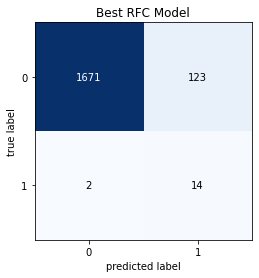

In [30]:
best_RFC_model.fit(X_train, y_train)
best_RFC_pred = best_RFC_model.predict(X_test)
best_RFC_cm_test = confusion_matrix(y_test, best_RFC_pred)
fig, ax = plot_confusion_matrix(conf_mat=best_RFC_cm_test)
plt.title('Best RFC Model')
plt.show()

**Trying truncatedSVD analysis on LR model**

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=16, train_size=0.75, stratify=y)

This paper messed with the SVD analysis, having PCA1 and PCA2 scores 100s of times higher than the others. All I can see is that it is the longest paper by ~10x and contains a lot of newlines

In [86]:
X_train.iloc[884]

Oral                                                          0.0
Poster                                                        1.0
Spotlight                                                     0.0
Unknown                                                       0.0
avg_word_len                                              0.42016
paper_len                                                     1.0
title_len                                                0.324503
year                                                     0.966667
paper_text      Learning Multiagent Communication\nwith Backpr...
Name: 2777, dtype: object

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=16, train_size=0.75, stratify=y)

other_features_train = csr_matrix(X_train[X_train.columns.difference(['paper_text'])].values)
other_features_test = csr_matrix(X_test[X_test.columns.difference(['paper_text'])].values)

tfidf = TfidfVectorizer()

X_train_vector = tfidf.fit_transform(X_train.paper_text)
X_test_vector = tfidf.transform(X_test.paper_text)

X_train = hstack([other_features_train, X_train_vector])
X_test = hstack([other_features_test, X_test_vector])

In [88]:
standard_scaler = StandardScaler(with_mean=False)

X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

In [89]:
tSVD = TruncatedSVD(n_components=2, random_state=21)

X_train = tSVD.fit_transform(X_train)
X_test = tSVD.transform(X_test)

In [90]:
PCAdf = pd.DataFrame(data=X_train, columns = ['PC1', 'PC2'])
y_df = pd.DataFrame(data=y_train, columns=['is_bernhard'])

PCAdf = pd.concat([PCAdf, y_df], axis = 1)
PCAdf.sort_values(by='is_bernhard', ascending=True, inplace=True)
PCAdf2 = PCAdf.drop(884)
PCAdf2.sort_values(by='is_bernhard', ascending=True, inplace=True)

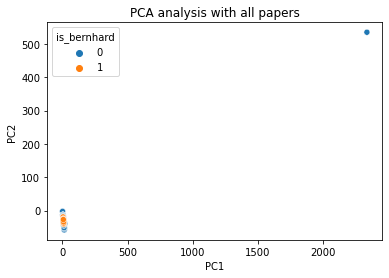

In [93]:
x_axis = PCAdf.PC1
y_axis = PCAdf.PC2

plt.subplots()
sns.scatterplot(x=x_axis, y=y_axis, hue=PCAdf.is_bernhard, data=PCAdf)
plt.title('PCA analysis with all papers')
plt.show()

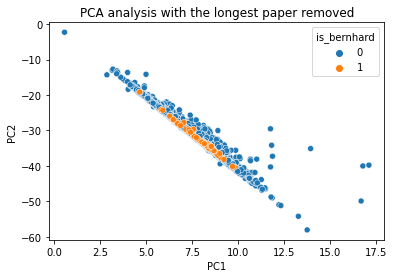

In [94]:
x_axis = PCAdf2.PC1
y_axis = PCAdf2.PC2

plt.subplots()
sns.scatterplot(x=x_axis, y=y_axis, hue=PCAdf2.is_bernhard, data=PCAdf2)
plt.title('PCA analysis with the longest paper removed')
plt.show()

Seeing what TruncatedSVD does to the LR model

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=16, train_size=0.75, stratify=y)

other_features_train = csr_matrix(X_train[X_train.columns.difference(['paper_text'])].values)
other_features_test = csr_matrix(X_test[X_test.columns.difference(['paper_text'])].values)

tfidf = TfidfVectorizer()

X_train_vector = tfidf.fit_transform(X_train.paper_text)
X_test_vector = tfidf.transform(X_test.paper_text)

X_train = hstack([other_features_train, X_train_vector])
X_test = hstack([other_features_test, X_test_vector])

In [97]:
standard_scaler = StandardScaler(with_mean=False)

X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

In [98]:
n_components = [2, 10, 50, 100, 300, 500, 1000]

In [99]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
SVD_dict = {'n_components' : [],
            'F2_score_train': [],
            'F2_score_test': []}

run = 0
best_score_F1 = 0
best_SVD_model = None

for n_component in n_components:

    # Counting what iteration I am on
    print(run)
    run += 1
    
    # Appending the parameters for this run to my dictionary
    SVD_dict['n_components'].append(n_component)

    # Making pipelines for each n_component
    tSVD = TruncatedSVD(n_components=n_component)

    X_train_SVD = tSVD.fit_transform(X_train)
    X_test_SVD = tSVD.transform(X_test)

    pipe = Pipeline(steps=[
            ('LR', LogisticRegression(class_weight='balanced', C=1, max_iter=2000))
            ])

    # Fitting the pipeline to the train set and predicting on both train and test sets
    pipe.fit(X_train_SVD, y_train)
    pipe_train_pred = pipe.predict(X_train_SVD)
    pipe_test_pred = pipe.predict(X_test_SVD)

    # Finding the roc_auc_score for both, I am including precision as in the past 
    # undersampling has led to awful precision scores
    F1_score_train = fbeta_score(y_train, pipe_train_pred, beta=2)
    F1_score_test = fbeta_score(y_test, pipe_test_pred, beta=2)

    # Appending the scores to the dictionary
    SVD_dict['F2_score_train'].append(F1_score_train)
    SVD_dict['F2_score_test'].append(F1_score_test)

    # Saving the best model
    if F1_score_test > best_score_F1:
        best_score_F1 = F1_score_test
        best_SVD_model = pipe

0
1
2
3
4
5
6


In [119]:
SVD_HPtable = pd.DataFrame.from_dict(SVD_dict) 
SVD_HPtable.sort_values(by='F2_score_test', ascending=False, inplace=True)
SVD_HPtable['Model'] = 'PCA'
SVD_HPtable

,n_components,F2_score_train,F2_score_test,Model
3,100,0.210477,0.163934,PCA
5,500,0.824373,0.147059,PCA
6,1000,1.000000,0.147059,PCA
2,50,0.142065,0.139319,PCA
4,300,0.507726,0.116279,PCA
1,10,0.059184,0.066578,PCA
0,2,0.061100,0.062785,PCA


In [101]:
tSVD = TruncatedSVD(n_components=100)

X_train_SVD = tSVD.fit_transform(X_train)
X_test_SVD = tSVD.transform(X_test)

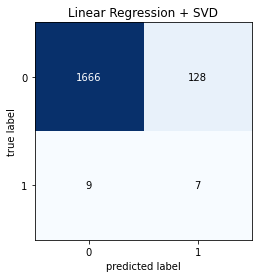

In [102]:
best_SVD_model.fit(X_train_SVD, y_train)
best_SVD_pred = best_SVD_model.predict(X_test_SVD)
SVD_test = confusion_matrix(y_test, best_SVD_pred)
fig, ax = plot_confusion_matrix(conf_mat=SVD_test)
plt.title('Linear Regression + SVD')
plt.show()

The final hyperparameter table for the non cross-validated tests. While it is somewhat messy to look at, it is clear that LinearSVC and LogisticRegression outperformed the rest of the models. These models, and the hyperparameters that worked best on them, are what I will be cross validating in the next section to determine the true best model.

In [129]:
ncv_HPtable = pd.concat([SVD_HPtable, RFC_HPtable, SVC_HPtable, LR_HPtable], axis=0)
ncv_HPtable.sort_values(by='F2_score_test', inplace=True, ascending=False)
ncv_HPtable

,n_components,F2_score_train,F2_score_test,Model,n_estimators,Sampler,SVC_C_value,LogReg_C_value,Precision,Train_auc,Test_auc
12,NaN,0.836364,0.523256,LinearSVC,NaN,None,0.10,NaN,NaN,NaN,NaN
16,NaN,0.836364,0.517241,LinearSVC,NaN,ros,0.05,NaN,NaN,NaN,NaN
15,NaN,0.730159,0.495050,LinearSVC,NaN,None,0.05,NaN,NaN,NaN,NaN
6,NaN,NaN,0.494505,LogisticRegression,NaN,None,NaN,1.0,0.333333,0.994334,0.776233
13,NaN,0.931174,0.493827,LinearSVC,NaN,ros,0.10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7,NaN,1.000000,0.000000,RandomForest,316.0,ros,NaN,NaN,NaN,NaN,NaN
9,NaN,1.000000,0.000000,RandomForest,562.0,None,NaN,NaN,NaN,NaN,NaN
10,NaN,1.000000,0.000000,RandomForest,562.0,ros,NaN,NaN,NaN,NaN,NaN
12,NaN,1.000000,0.000000,RandomForest,1000.0,None,NaN,NaN,NaN,NaN,NaN


In [48]:
C = [5, 1, 0.5, 0.1]

In [49]:
samplers = ['None', 'ros']

In [50]:
hyperparameters = list(itertools.product(
                        C, samplers
))

hyperparameters

[(5, 'None'),
 (5, 'ros'),
 (1, 'None'),
 (1, 'ros'),
 (0.5, 'None'),
 (0.5, 'ros'),
 (0.1, 'None'),
 (0.1, 'ros')]

In [51]:
random_states = [0, 1, 2, 3, 4]

In [52]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
LR_dict_final = {'LogReg_C_value' : [],
            'Sampler': [],
            'F2_score_train_avg': [],
            'F2_score_test_avg':[]}

run = 0

for C_value, sampler_type in hyperparameters:

    # Counting what iteration I am on
    print(run)
    run += 1
    
    # Appending the parameters for this run to my dictionary
    LR_dict_final['LogReg_C_value'].append(C_value)
    LR_dict_final['Sampler'].append(sampler_type)

    F1_train_scores = []
    F1_test_scores = []
    for random_state in random_states:

        # For each random state create a new train/test split and re-TfidfVectorize
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, train_size=0.75, stratify=y)

        other_features_train = csr_matrix(X_train[X_train.columns.difference(['paper_text'])].values)
        other_features_test = csr_matrix(X_test[X_test.columns.difference(['paper_text'])].values)

        tfidf = TfidfVectorizer()

        X_train_vector = tfidf.fit_transform(X_train.paper_text)
        X_test_vector = tfidf.transform(X_test.paper_text)

        X_train = hstack([other_features_train, X_train_vector])
        X_test = hstack([other_features_test, X_test_vector])

        # Making pipelines for each sampler type, with the C value used within
        if sampler_type == 'ros':
            pipe = Pipeline(steps=[
                ('ros', RandomOverSampler(random_state=21)),
                ('LR', LogisticRegression(C=C_value, max_iter = 1000))
                ])

        else:
            pipe = Pipeline(steps=[
                ('LR', LogisticRegression(class_weight='balanced', C=C_value, max_iter = 1000))
                ])

        # Fitting the pipeline to the train set and predicting on both train and test sets
        pipe.fit(X_train, y_train)
        pipe_train_pred = pipe.predict(X_train)
        pipe_test_pred = pipe.predict(X_test)

        # Finding the roc_auc_score for both, I am including precision as in the past 
        # undersampling has led to awful precision scores
        F1_score_train = fbeta_score(y_train, pipe_train_pred, beta=2)
        F1_score_test = fbeta_score(y_test, pipe_test_pred, beta=2)

        #Appending the scores to the list outside the loop
        F1_train_scores.append(F1_score_train)
        F1_test_scores.append(F1_score_test)
        
    # Appending the scores to the dictionary
    LR_dict_final['F2_score_train_avg'].append(mean(F1_train_scores))
    LR_dict_final['F2_score_test_avg'].append(mean(F1_test_scores))


0
1
2
3
4
5
6
7


In [53]:
LR_final_HPtable = pd.DataFrame.from_dict(LR_dict_final) 
LR_final_HPtable.sort_values(by='F2_score_test_avg', ascending=False, inplace=True)
LR_final_HPtable

,LogReg_C_value,Sampler,F2_score_train_avg,F2_score_test_avg
3,1.0,ros,0.874637,0.453942
5,0.5,ros,0.801624,0.432396
2,1.0,None,0.804469,0.422821
1,5.0,ros,0.963199,0.419485
0,5.0,None,0.938869,0.412721
4,0.5,None,0.727039,0.410570
7,0.1,ros,0.620793,0.377157
6,0.1,None,0.529520,0.335698


Cross validating the SVC model

In [54]:
C = [1, 0.5, 0.1, 0.05]

In [55]:
samplers = ['None', 'ros']

In [56]:
hyperparameters = list(itertools.product(
                        C, samplers
))

hyperparameters

[(1, 'None'),
 (1, 'ros'),
 (0.5, 'None'),
 (0.5, 'ros'),
 (0.1, 'None'),
 (0.1, 'ros'),
 (0.05, 'None'),
 (0.05, 'ros')]

In [57]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
SVC_dict_final = {'SVC_C_value' : [],
            'Sampler': [],
            'F2_score_train_avg': [],
            'F2_score_test_avg':[]}

run = 0

for C_value, sampler_type in hyperparameters:

    # Counting what iteration I am on
    print(run)
    run += 1
    
    # Appending the parameters for this run to my dictionary
    SVC_dict_final['SVC_C_value'].append(C_value)
    SVC_dict_final['Sampler'].append(sampler_type)

    F1_train_scores = []
    F1_test_scores = []
    for random_state in random_states:

        # For each random state create a new train/test split and re-TfidfVectorize
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, train_size=0.75, stratify=y)

        other_features_train = csr_matrix(X_train[X_train.columns.difference(['paper_text'])].values)
        other_features_test = csr_matrix(X_test[X_test.columns.difference(['paper_text'])].values)

        tfidf = TfidfVectorizer()

        X_train_vector = tfidf.fit_transform(X_train.paper_text)
        X_test_vector = tfidf.transform(X_test.paper_text)

        X_train = hstack([other_features_train, X_train_vector])
        X_test = hstack([other_features_test, X_test_vector])

        # Making pipelines for each sampler type, with the C value used within
        if sampler_type == 'ros':
            pipe = Pipeline(steps=[
                ('ros', RandomOverSampler(random_state=21)),
                ('SVC', LinearSVC(C=C_value))
                ])

        else:
            pipe = Pipeline(steps=[
                ('SVC', LinearSVC(class_weight='balanced', C=C_value, max_iter = 1000))
                ])

        # Fitting the pipeline to the train set and predicting on both train and test sets
        pipe.fit(X_train, y_train)
        pipe_train_pred = pipe.predict(X_train)
        pipe_test_pred = pipe.predict(X_test)

        # Finding the roc_auc_score for both, I am including precision as in the past 
        # undersampling has led to awful precision scores
        F1_score_train = fbeta_score(y_train, pipe_train_pred, beta=2)
        F1_score_test = fbeta_score(y_test, pipe_test_pred, beta=2)

        #Appending the scores to the list outside the loop
        F1_train_scores.append(F1_score_train)
        F1_test_scores.append(F1_score_test)
        
    # Appending the scores to the dictionary
    SVC_dict_final['F2_score_train_avg'].append(mean(F1_train_scores))
    SVC_dict_final['F2_score_test_avg'].append(mean(F1_test_scores))

0
1
2
3
4
5
6
7


In [58]:
SVC_final_HPtable = pd.DataFrame.from_dict(SVC_dict_final) 
SVC_final_HPtable.sort_values(by='F2_score_test_avg', ascending=False, inplace=True)
SVC_final_HPtable

,SVC_C_value,Sampler,F2_score_train_avg,F2_score_test_avg
4,0.10,None,0.839164,0.462798
7,0.05,ros,0.837961,0.461768
5,0.10,ros,0.917847,0.445585
6,0.05,None,0.744874,0.434137
2,0.50,None,0.973788,0.406411
0,1.00,None,0.993111,0.361382
3,0.50,ros,0.992245,0.361382
1,1.00,ros,0.998268,0.297756


The combined hyperparameter table shows that LinearSVC generally outperformed LogisticRegression as a model based on F2_score. However, LinearSVC does not support predict_proba, and finding the probability of an author writing a paper is where the model is most useful. Using CalibratedClassifierCV to find the probabilities creates other problems, like removing the ability to check feature importance and interfering with the MultioutputClassifier used in the next notebook. Therefore, the LogisticRegression model with a C=1 and randomly oversampled is the best model I can use. 

In [118]:
final_HPtable = pd.concat([SVC_final_HPtable, LR_final_HPtable], axis=0)
final_HPtable.fillna('NaN', inplace=True)
final_HPtable['Model'] = np.where(final_HPtable['SVC_C_value']=='NaN', 'LogisticRegression', 'SVC')
final_HPtable = final_HPtable[['LogReg_C_value', 'SVC_C_value', 'Sampler', 'F2_score_train_avg', 'F2_score_test_avg', 'Model']]
final_HPtable.sort_values(by='F2_score_test_avg', inplace=True, ascending=False)
final_HPtable

,LogReg_C_value,SVC_C_value,Sampler,F2_score_train_avg,F2_score_test_avg,Model
4,NaN,0.1,None,0.839164,0.462798,SVC
7,NaN,0.05,ros,0.837961,0.461768,SVC
3,1.0,NaN,ros,0.874637,0.453942,LogisticRegression
5,NaN,0.1,ros,0.917847,0.445585,SVC
6,NaN,0.05,None,0.744874,0.434137,SVC
5,0.5,NaN,ros,0.801624,0.432396,LogisticRegression
2,1.0,NaN,None,0.804469,0.422821,LogisticRegression
1,5.0,NaN,ros,0.963199,0.419485,LogisticRegression
0,5.0,NaN,None,0.938869,0.412721,LogisticRegression
4,0.5,NaN,None,0.727039,0.410570,LogisticRegression


Checking feature importance in optimal pipeline

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=16, train_size=0.75, stratify=y)

other_features_train = csr_matrix(X_train[X_train.columns.difference(['paper_text'])].values)
other_features_test = csr_matrix(X_test[X_test.columns.difference(['paper_text'])].values)

tfidf = TfidfVectorizer(stop_words=['scholkopf'])

X_train_vector = tfidf.fit_transform(X_train.paper_text)
X_test_vector = tfidf.transform(X_test.paper_text)

X_train = hstack([other_features_train, X_train_vector])
X_test = hstack([other_features_test, X_test_vector])


In [60]:
pipe = Pipeline(steps=[
                ('LR', LogisticRegression(C=1, class_weight='balanced', max_iter=1000))
                ])

In [61]:
pipe.fit(X_train, y_train)
pipe_train_pred = pipe.predict(X_train)
pipe_test_pred = pipe.predict(X_test)

In [62]:
F1_score_train = fbeta_score(y_train, pipe_train_pred, beta=2)
F1_score_test = fbeta_score(y_test, pipe_test_pred, beta=2)
print(F1_score_train)
print(F1_score_test)

0.7849829351535836
0.48387096774193544


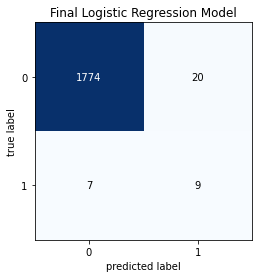

In [63]:
Final_test = confusion_matrix(y_test, pipe_test_pred)
fig, ax = plot_confusion_matrix(conf_mat=Final_test)
plt.title('Final Logistic Regression Model')
plt.show()

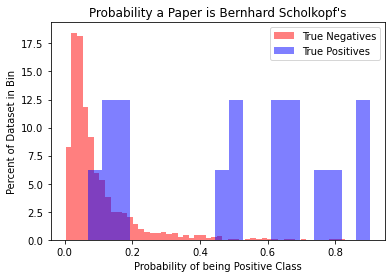

In [64]:
pipe_predict_proba = pipe.predict_proba(X_test)

neg_weights = 100 * np.ones_like(pipe_predict_proba[:, 1][y_test==0]) / len(pipe_predict_proba[:, 1][y_test==0])
pos_weights = 100 * np.ones_like(pipe_predict_proba[:, 1][y_test==1]) / len(pipe_predict_proba[:, 1][y_test==1])

plt.hist(pipe_predict_proba[:, 1][y_test==0], color='Red', alpha=0.5, label='True Negatives', bins=50, weights=neg_weights)
plt.hist(pipe_predict_proba[:, 1][y_test==1], color='Blue', alpha=0.5, label='True Positives', bins=20, weights=pos_weights)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Percent of Dataset in Bin')
plt.title('Probability a Paper is Bernhard Scholkopf\'s')
plt.legend()
plt.show()

In [65]:
columns = ['Oral', 'Poster', 'Spotlight', 'Unknown', 'avg_word_len', 'paper_len']
for feature_name in tfidf.get_feature_names_out():
    columns.append(feature_name)
columns.append('title_len')
columns.append('year')

In [66]:
feature_imp_df = pd.DataFrame(pipe.named_steps['LR'].coef_, columns=columns)
feature_imp_df = feature_imp_df.T.reset_index().rename(columns={0:'value', 'index':'feature'})
feature_imp_df.sort_values(by='value', ascending=False, inplace=True)
feature_imp_df

,feature,value
104475,kernel10,5.424836
177683,tq1,3.861011
91345,hypergrid,3.353950
165132,smola2,3.313332
98262,ipglon,3.288715
...,...,...
110070,learning2,-1.469898
32593,algorithm2,-1.524486
175928,time10,-1.692383
127686,network2,-1.869916
